In [11]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import itertools
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [12]:
window_size = 25
train = pd.read_csv("./data/train.csv")
stocks = range(0,200)
train = train.sort_values(['date_id','time_id'])
train['wap'] = train['wap'].fillna(train['wap'].mean())
scaler =  MinMaxScaler()
targetScaler = MinMaxScaler()
train['wap_scaled'] = scaler.fit_transform(train['wap'].to_numpy().reshape(-1, 1)).squeeze()
train['target_scaled'] = targetScaler.fit_transform(train['target'].to_numpy().reshape(-1, 1)).squeeze()
table = pd.pivot_table(train,values=['wap_scaled','target_scaled'],columns=['stock_id'],index=['date_id','time_id'])


table.fillna(method='bfill',inplace=True)
table.fillna(method='ffill',inplace=True)

print(table.head())
table.isna().sum()

                target_scaled                                          \
stock_id                  0         1         2         3         4     
date_id time_id                                                         
0       0            0.459801  0.456805  0.453353  0.458621  0.454604   
        1            0.463914  0.461496  0.454472  0.462194  0.455362   
        2            0.468521  0.455675  0.455771  0.461003  0.462615   
        3            0.470001  0.457251  0.456445  0.464804  0.460330   
        4            0.467258  0.455326  0.463108  0.460618  0.457551   

                                                                   ...  \
stock_id              5         6         7         8         9    ...   
date_id time_id                                                    ...   
0       0        0.471600  0.460438  0.461088  0.456264  0.473032  ...   
        1        0.472720  0.458297  0.453810  0.462507  0.462675  ...   
        2        0.464660  0.466970  0.448927

C:\Users\adams\AppData\Local\Temp\ipykernel_5440\766936000.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='bfill',inplace=True)
C:\Users\adams\AppData\Local\Temp\ipykernel_5440\766936000.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table.fillna(method='ffill',inplace=True)


               stock_id
target_scaled  0           0
               1           0
               2           0
               3           0
               4           0
                          ..
wap_scaled     195         0
               196         0
               197         0
               198         0
               199         0
Length: 400, dtype: int64

In [13]:
def create_lagged_with_target(data,stock,var,window_size,forecast_dist,target):
    var_data = data[var][stock]
    target_data = data[target][stock]
    y = target_data.iloc[window_size+forecast_dist:]
    var_data = var_data.values.reshape(-1,1)
    n = data.shape[0]
    X = np.hstack(tuple([var_data[i: n-j, :] for i, j in enumerate(range(window_size,0,-1))]))
    X = X[:X.shape[0]-forecast_dist]
    y.reset_index()
    return pd.DataFrame(X,index=y.index).to_numpy(), y.to_numpy()

In [14]:
class TimeModel(nn.Module):
    def __init__(self,window_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=window_size, hidden_size=50, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(50, 50)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(50, 1)
        self.to(torch.float32)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x.type(torch.float32)

In [15]:

X_train = {}
y_train = {}
X_test = {}
y_test = {}
for stock in stocks:
    print("getting forcasts for stock: ",stock)
    forecaster = TimeModel(window_size=window_size)
    forecaster.load_state_dict(torch.load('models/lstm/model_{}'.format(stock)))
    X, y = create_lagged_with_target(table,stock,'wap_scaled',window_size,6,'target_scaled')

    size = int(X.shape[0]*.9)
    X_pre_train = torch.tensor(X[:size]).to(torch.float32)
    X_pre_test = torch.tensor(X[size:]).to(torch.float32)
    X_train[stock] = forecaster(X_pre_train).detach().numpy()
    X_train[stock] = list(itertools.chain.from_iterable(X_train[stock]))
    y_train[stock] = y[:size]

    X_test[stock] = forecaster(X_pre_test).detach().numpy()
    X_test[stock] = list(itertools.chain.from_iterable(X_test[stock]))
    y_test[stock] = y[size:]

    if stock % 50 == 0 and stock != 0:
        pd.DataFrame(X_train).to_csv('data/forecasts/X_train_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(y_train).to_csv('data/forecasts/y_train_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(X_test).to_csv('data/forecasts/X_test_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(y_test).to_csv('data/forecasts/y_test_forcasts{0}-{1}'.format(stock-50,stock),index=False)

        X_train = {}
        y_train = {}
        X_test = {}
        y_test = {}
        
pd.DataFrame(X_train).to_csv('data/forecasts/X_train_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(y_train).to_csv('data/forecasts/y_train_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(X_test).to_csv('data/forecasts/X_test_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(y_test).to_csv('data/forecasts/y_test_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)


getting forcasts for stock:  0
getting forcasts for stock:  1
getting forcasts for stock:  2
getting forcasts for stock:  3
getting forcasts for stock:  4
getting forcasts for stock:  5
getting forcasts for stock:  6
getting forcasts for stock:  7
getting forcasts for stock:  8
getting forcasts for stock:  9
getting forcasts for stock:  10
getting forcasts for stock:  11
getting forcasts for stock:  12
getting forcasts for stock:  13
getting forcasts for stock:  14
getting forcasts for stock:  15
getting forcasts for stock:  16
getting forcasts for stock:  17
getting forcasts for stock:  18
getting forcasts for stock:  19
getting forcasts for stock:  20
getting forcasts for stock:  21
getting forcasts for stock:  22
getting forcasts for stock:  23
getting forcasts for stock:  24
getting forcasts for stock:  25
getting forcasts for stock:  26
getting forcasts for stock:  27
getting forcasts for stock:  28
getting forcasts for stock:  29
getting forcasts for stock:  30
getting forcasts f

In [16]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()
for x in range(4):
    X_train = pd.concat([X_train,pd.read_csv('data/forecasts/X_train_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    X_test = pd.concat([X_test,pd.read_csv('data/forecasts/X_test_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    y_train = pd.concat([y_train,pd.read_csv('data/forecasts/y_train_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    y_test = pd.concat([y_test,pd.read_csv('data/forecasts/y_test_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
                                            

In [17]:
class TargetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(200,300)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(300, 300)
        self.linear3 = nn.Linear(300, 200)
        self.to(torch.float32)
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x.type(torch.float32)

In [18]:
def train_model(X_train,y_train,X_test,y_test):
    model = TargetModel()
    #model.to(torch.float32).to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.L1Loss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=100)
    early_stop_best = np.inf
    early_stop_count = 0
    max_stop_count = 10
    n_epochs = 2000
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            X_batch = X_batch
            y_batch = y_batch
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_batch)
            train_mse = loss_fn(y_pred, y_batch)
            y_pred = model(X_test)
            test_mse = loss_fn(y_pred, y_test)#.to(device))
            if test_mse < early_stop_best:
                best_model = model
                early_stop_best = test_mse
                early_stop_count = 0 
                print('best loss:',early_stop_best)
        print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_mse, test_mse))
        early_stop_count += 1
        print(early_stop_count)
        if early_stop_count >= max_stop_count:
            return best_model

    return best_model

In [19]:
X_train = torch.tensor(scaler.fit_transform(X_train)).to(torch.float32)
y_train = torch.tensor(y_train.to_numpy()).to(torch.float32)
X_test = torch.tensor(scaler.fit_transform(X_test)).to(torch.float32)
y_test = torch.tensor(y_test.to_numpy()).to(torch.float32)

model = train_model(X_train,y_train,X_test,y_test)
#print(model.score(X_test,y_test))

y_hat = model(X_test)
mean_absolute_error(targetScaler.inverse_transform(y_test.detach().numpy()),targetScaler.inverse_transform(y_hat.detach().numpy()))


c:\Users\adams\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\adams\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\adams\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\adams\anaconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtyp

best loss: tensor(0.0292)
Epoch 0: train MSE 0.0157, test MSE 0.0292
1
best loss: tensor(0.0094)
Epoch 10: train MSE 0.0064, test MSE 0.0094
1
best loss: tensor(0.0087)
Epoch 20: train MSE 0.0065, test MSE 0.0087
1
best loss: tensor(0.0077)
Epoch 30: train MSE 0.0064, test MSE 0.0077
1
Epoch 40: train MSE 0.0063, test MSE 0.0077
2
best loss: tensor(0.0075)
Epoch 50: train MSE 0.0063, test MSE 0.0075
1
best loss: tensor(0.0075)
Epoch 60: train MSE 0.0063, test MSE 0.0075
1
Epoch 70: train MSE 0.0063, test MSE 0.0075
2
Epoch 80: train MSE 0.0062, test MSE 0.0075
3
best loss: tensor(0.0075)
Epoch 90: train MSE 0.0062, test MSE 0.0075
1
Epoch 100: train MSE 0.0062, test MSE 0.0075
2
best loss: tensor(0.0075)
Epoch 110: train MSE 0.0063, test MSE 0.0075
1
Epoch 120: train MSE 0.0062, test MSE 0.0075
2
best loss: tensor(0.0074)
Epoch 130: train MSE 0.0062, test MSE 0.0074
1
Epoch 140: train MSE 0.0062, test MSE 0.0075
2
Epoch 150: train MSE 0.0063, test MSE 0.0075
3
Epoch 160: train MSE 0.00

6.1332107

<Axes: >

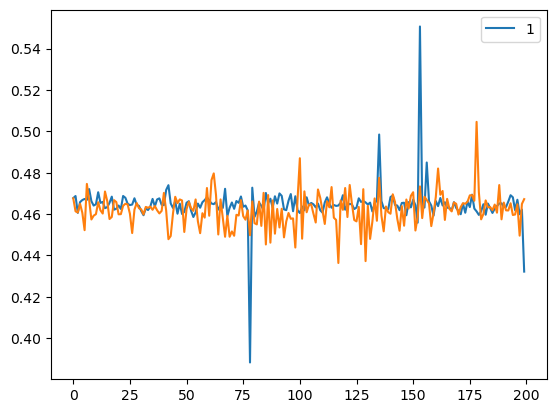

In [20]:
y_hat_df = pd.DataFrame(y_hat.detach().numpy())
y_test_df  =pd.DataFrame(y_test.detach().numpy())
y_hat_df.iloc[1].plot(legend=True)
y_test_df.iloc[1].plot()